In [1]:
import argparse, random, numpy as np, torch, gc
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, models
from torchvision.datasets import EuroSAT
from tqdm import tqdm
from contextlib import nullcontext
import matplotlib.pyplot as plt

In [2]:
# ---------- 1. 參數 ----------
parser = argparse.ArgumentParser()
parser.add_argument('--data_dir', type=str, default='./data')
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--epochs', type=int, default=64)
parser.add_argument('--lr', type=float, default=5e-4)
parser.add_argument('--accum_steps', type=int, default=1,
                    help='梯度累積步數')
parser.add_argument('--variant', '-v', choices=['s', 'm', 'l'], default='m')
parser.add_argument('--freeze_backbone', action='store_true')
args, _ = parser.parse_known_args()

# ---------- 2. 環境 ----------
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42); random.seed(42); np.random.seed(42)

try:
    from torch.amp import autocast as _ac
    def amp_ctx(): return _ac(device_type=DEVICE) if DEVICE == 'cuda' else nullcontext()
except ImportError:
    from torch.cuda.amp import autocast as _ac
    def amp_ctx(): return _ac() if DEVICE == 'cuda' else nullcontext()

from torch.cuda.amp import GradScaler
scaler = GradScaler(enabled=(DEVICE == 'cuda'))

# ---------- 3. 資料 ----------
tfm = transforms.Compose([
    transforms.Resize(224, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = EuroSAT(args.data_dir, download=True, transform=tfm)
n_total = len(dataset); n_val = n_test = n_total // 10
n_train = n_total - n_val - n_test
train_set, val_set, test_set = random_split(
    dataset, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

def make_loader(split, bs):
    return DataLoader(split, batch_size=bs,
                      shuffle=(split is train_set),
                      num_workers=2, pin_memory=True)

train_loader = make_loader(train_set, args.batch_size)
val_loader   = make_loader(val_set,   args.batch_size)
test_loader  = make_loader(test_set,  args.batch_size)
num_classes = len(dataset.classes)

<ipython-input-2-15100424e4fe>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE == 'cuda'))
100%|██████████| 94.3M/94.3M [00:00<00:00, 204MB/s]


In [3]:
# ---------- 4. 模型 ----------
v = args.variant
if v == 's':
    net = models.efficientnet_v2_s(
        weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
elif v == 'm':
    net = models.efficientnet_v2_m(
        weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
else:
    net = models.efficientnet_v2_l(
        weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

net.classifier[1] = nn.Linear(net.classifier[1].in_features, num_classes)

if args.freeze_backbone:
    for n, p in net.named_parameters():
        if not n.startswith('classifier'):
            p.requires_grad = False
    print('Backbone frozen；僅微調分類頭')

net = net.to(DEVICE)
criterion = nn.CrossEntropyLoss()
opt = optim.AdamW([p for p in net.parameters() if p.requires_grad],
                  lr=args.lr, weight_decay=1e-4)
sched = ReduceLROnPlateau(opt, 'min', patience=2, factor=0.5, verbose=True)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:02<00:00, 88.4MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [4]:
# ---------- 5. 訓練 ----------
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

def forward_step(x, y):
    with amp_ctx():
        pred = net(x)
        loss = criterion(pred, y)
    return loss, pred

best_val = 0; stale = 0
for ep in range(1, args.epochs + 1):
    net.train()
    tloss = tcorrect = ttotal = 0
    opt.zero_grad(set_to_none=True)

    for idx, (x, y) in enumerate(tqdm(train_loader, desc=f'Epoch {ep}/{args.epochs}')):
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        try:
            loss, pred = forward_step(x, y)
        except RuntimeError as e:
            if 'out of memory' in str(e):
                print('CUDA OOM，調小 --batch_size 或加大 --accum_steps')
                torch.cuda.empty_cache(); gc.collect()
                raise e
        scaler.scale(loss / args.accum_steps).backward()
        tcorrect += (pred.argmax(1) == y).sum().item()
        ttotal   += y.size(0)
        tloss    += loss.item() * y.size(0)

        if (idx + 1) % args.accum_steps == 0:
            scaler.step(opt); scaler.update()
            opt.zero_grad(set_to_none=True)

    train_loss = tloss / ttotal
    train_acc  = tcorrect / ttotal

    # ----- 驗證 -----
    net.eval()
    vloss = vcorrect = vtotal = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            loss, pred = forward_step(x, y)
            vloss    += loss.item() * y.size(0)
            vcorrect += (pred.argmax(1) == y).sum().item()
            vtotal   += y.size(0)
    val_loss = vloss / vtotal
    val_acc  = vcorrect / vtotal

    # 紀錄
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    sched.step(val_loss)

    if val_acc > best_val:
        best_val, stale = val_acc, 0
        torch.save(net.state_dict(), f'best_effv2_{v}.pt')
    else:
        stale += 1
        if stale >= 5:
            print('Early stopping'); break

    print(f'Epoch {ep:02d} | '
          f'train_loss {train_loss:.4f} train_acc {train_acc:.4f} | '
          f'val_loss {val_loss:.4f} val_acc {val_acc:.4f}')

Epoch 1/64: 100%|██████████| 338/338 [03:06<00:00,  1.81it/s]


Epoch 01 | train_loss 0.2283 train_acc 0.9297 | val_loss 0.0871 val_acc 0.9707


Epoch 2/64: 100%|██████████| 338/338 [03:04<00:00,  1.83it/s]


Epoch 02 | train_loss 0.0839 train_acc 0.9738 | val_loss 0.0787 val_acc 0.9733


Epoch 3/64: 100%|██████████| 338/338 [03:02<00:00,  1.85it/s]


Epoch 03 | train_loss 0.0573 train_acc 0.9820 | val_loss 0.0974 val_acc 0.9667


Epoch 4/64: 100%|██████████| 338/338 [03:02<00:00,  1.85it/s]


Epoch 04 | train_loss 0.0548 train_acc 0.9823 | val_loss 0.0745 val_acc 0.9789


Epoch 5/64: 100%|██████████| 338/338 [03:02<00:00,  1.85it/s]


Epoch 05 | train_loss 0.0465 train_acc 0.9844 | val_loss 0.1527 val_acc 0.9556


Epoch 6/64: 100%|██████████| 338/338 [03:02<00:00,  1.85it/s]


Epoch 06 | train_loss 0.0412 train_acc 0.9866 | val_loss 0.0773 val_acc 0.9774


Epoch 7/64: 100%|██████████| 338/338 [03:02<00:00,  1.85it/s]


Epoch 07 | train_loss 0.0334 train_acc 0.9887 | val_loss 0.0875 val_acc 0.9752


Epoch 8/64: 100%|██████████| 338/338 [03:02<00:00,  1.86it/s]


Epoch 08 | train_loss 0.0106 train_acc 0.9969 | val_loss 0.0533 val_acc 0.9867


Epoch 9/64: 100%|██████████| 338/338 [03:01<00:00,  1.86it/s]


Epoch 09 | train_loss 0.0044 train_acc 0.9987 | val_loss 0.0702 val_acc 0.9833


Epoch 10/64: 100%|██████████| 338/338 [03:01<00:00,  1.86it/s]


Epoch 10 | train_loss 0.0068 train_acc 0.9979 | val_loss 0.0663 val_acc 0.9856


Epoch 11/64: 100%|██████████| 338/338 [03:01<00:00,  1.86it/s]


Epoch 11 | train_loss 0.0078 train_acc 0.9975 | val_loss 0.0716 val_acc 0.9844


Epoch 12/64: 100%|██████████| 338/338 [03:02<00:00,  1.86it/s]


Epoch 12 | train_loss 0.0034 train_acc 0.9988 | val_loss 0.0676 val_acc 0.9859


Epoch 13/64: 100%|██████████| 338/338 [03:01<00:00,  1.86it/s]


Epoch 13 | train_loss 0.0008 train_acc 0.9998 | val_loss 0.0684 val_acc 0.9874


Epoch 14/64: 100%|██████████| 338/338 [03:01<00:00,  1.86it/s]


Epoch 14 | train_loss 0.0016 train_acc 0.9996 | val_loss 0.0625 val_acc 0.9852


Epoch 15/64: 100%|██████████| 338/338 [03:01<00:00,  1.87it/s]


Epoch 15 | train_loss 0.0006 train_acc 0.9998 | val_loss 0.0676 val_acc 0.9863


Epoch 16/64: 100%|██████████| 338/338 [03:01<00:00,  1.87it/s]


Epoch 16 | train_loss 0.0014 train_acc 0.9997 | val_loss 0.0685 val_acc 0.9885


Epoch 17/64: 100%|██████████| 338/338 [03:01<00:00,  1.87it/s]


Epoch 17 | train_loss 0.0006 train_acc 0.9998 | val_loss 0.0691 val_acc 0.9881


Epoch 18/64: 100%|██████████| 338/338 [03:00<00:00,  1.87it/s]


Epoch 18 | train_loss 0.0002 train_acc 1.0000 | val_loss 0.0670 val_acc 0.9870


Epoch 19/64: 100%|██████████| 338/338 [03:00<00:00,  1.87it/s]


Epoch 19 | train_loss 0.0003 train_acc 1.0000 | val_loss 0.0680 val_acc 0.9878


Epoch 20/64: 100%|██████████| 338/338 [03:00<00:00,  1.88it/s]


Epoch 20 | train_loss 0.0003 train_acc 0.9999 | val_loss 0.0688 val_acc 0.9885


Epoch 21/64: 100%|██████████| 338/338 [03:00<00:00,  1.88it/s]


Early stopping


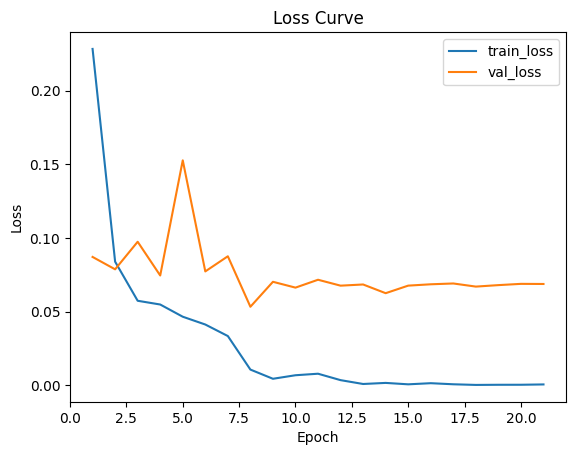

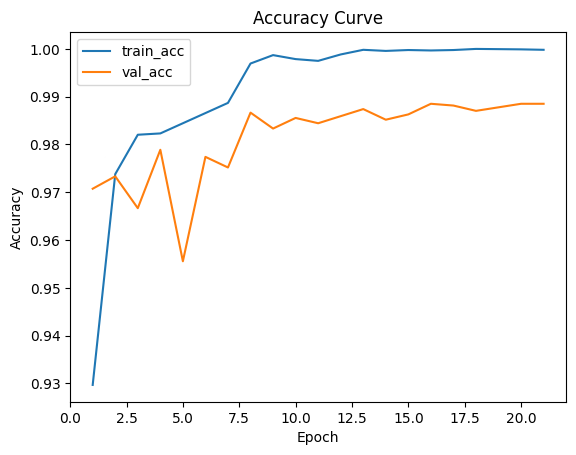

In [5]:
# ---------- 6. 繪圖 ----------
epochs = range(1, len(history['train_loss']) + 1)

# Loss 曲線
plt.figure()
plt.plot(epochs, history['train_loss'], label='train_loss')
plt.plot(epochs, history['val_loss'],   label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend()
plt.savefig('loss_curve.png', dpi=300, bbox_inches='tight')   # ← 新增
plt.show()

# Accuracy 曲線
plt.figure()
plt.plot(epochs, history['train_acc'], label='train_acc')
plt.plot(epochs, history['val_acc'],   label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend()
plt.savefig('accuracy_curve.png', dpi=300, bbox_inches='tight')  # ← 新增
plt.show()


In [6]:
# ---------- 7. 測試 ----------
from sklearn.metrics import classification_report
net.load_state_dict(torch.load(f'best_effv2_{v}.pt', map_location=DEVICE))
net.eval()
preds, labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE, non_blocking=True)
        _, pred = forward_step(x, y.to(DEVICE))
        preds.extend(pred.argmax(1).cpu().numpy())
        labels.extend(y.numpy())

print(classification_report(labels, preds, target_names=dataset.classes, digits=4))

                      precision    recall  f1-score   support

          AnnualCrop     0.9770    0.9933    0.9851       300
              Forest     0.9933    0.9966    0.9950       297
HerbaceousVegetation     0.9901    0.9901    0.9901       302
             Highway     0.9853    0.9963    0.9908       269
          Industrial     0.9922    0.9844    0.9883       257
             Pasture     0.9837    0.9679    0.9757       187
       PermanentCrop     0.9842    0.9803    0.9822       254
         Residential     0.9904    0.9904    0.9904       314
               River     0.9959    0.9837    0.9897       245
             SeaLake     0.9964    0.9964    0.9964       275

            accuracy                         0.9889      2700
           macro avg     0.9888    0.9879    0.9884      2700
        weighted avg     0.9889    0.9889    0.9889      2700

